# Final Project Baseline
Yang Wei Neo, Emily Rapport, Hilary Yamtich

## Load Libraries and Data

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import csv
from rfpimp import *
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor

# note: this notebook requires pandas 0.21.0 or newer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shared_functions as sf
import math
from datetime import datetime as dt
import re as re
import pickle as pk
from sklearn.pipeline import Pipeline

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

from dateutil import parser
import datetime

In [2]:
# Basic EDA
# The training data needs to be saved in the same location.
original_data = pd.read_csv('train.csv')
data = original_data.copy()

# Background to the problem

### The Dataset and Framing the Problem

The goal of this problem is to use the Ames Housing Dataset to create a model to predict the sale prices of homes randomly selected from within the original dataset. 

The Ames Housing Dataset was compiled by Dean De Cock in 2011. It is based on all the housing sales that occured in Ames, Iowa during the period from 2006 to 2010. It was created as an alternative to the Boston Housing Dataset and it includes more feature variables (79) that are related to housing price. The original dataset included 2,390 observations. The goal of the creator was to include a wider set of explanatory variables than the original Boston Housing Dataset to allow for more advanced regression techniques to be applied.

The problem itself is based on Kaggle competition to use advanced regression techniques to create a model to predict the sale price of a home. The test data is randomly selected from within the original Ames Housing Dataset. The training dataset used in the Kaggle competition includes 1,460 observations. The goal is to accurately predict the sale prices of the homes in the test set.

### Distribution of Sale Price Variable

First we look at the distribution of the sale price variable using a histogram.

Text(0.5,0,'Sale Prices')

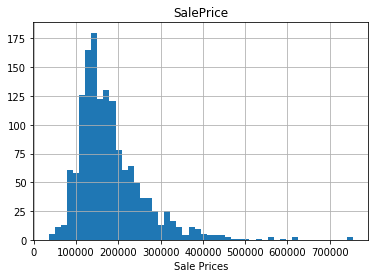

In [3]:
data.hist("SalePrice", bins = 50)
plt.xlabel("Sale Prices")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0a8745f8>]],
      dtype=object)

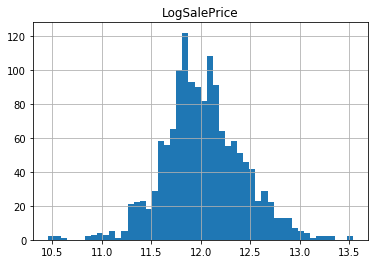

In [4]:
data["LogSalePrice"] = np.log(data["SalePrice"])
data.hist("LogSalePrice", bins = 50)

This produces a more normally distributed set of data. This makes our highly skewed distribution less skewed and allows our sale price data to meet the assumptions of inferential statistics and linear regression.

## Exploratory Data Analysis

## Feature Engineering

### Overview

We have two broad approaches to feature engineering - 'top down' and 'bottom up'. 

In the 'top down' case, we start with all the variables and work to eliminate / simplify variables as much as possible. We remove features with little useful variation (mostly missing, or heavily imbalanced) and features that are highly correlated for obvious reasons (e.g. total square feet and other component square feet). These should help to reduce the likelihood of overfitting and help improve interpretability. 

In the 'bottom up' case, we use various algorithmic feature selection techniques (e.g. random forest feature importance) and choose the top 10. This helps us construct the most parsimonious feature set to compare our more complete feature set against. 

In both cases, we also make several variable transformations - imputing missing features, or one-hot-encoding categorical features, for instance. They are listed below. 

### Remove features with very little variation and those that are missing for most observations

Based on this heatmap of missing variables we see that Alley, PoolQC, Fence and MiscFeature are missing for most values in the dataset. This makes sense, as these are more esoteric features of the house. In the same vein, there is also very little variation in Street, Utilities, LowQualFinSF and MiscVal. For example, most of these houses have all the utilities except for one. While this may ultimately be an important predictor, we believe that this is more likely to overfit and not generalize (after all this observation can only be in validation or train) for any given fold.

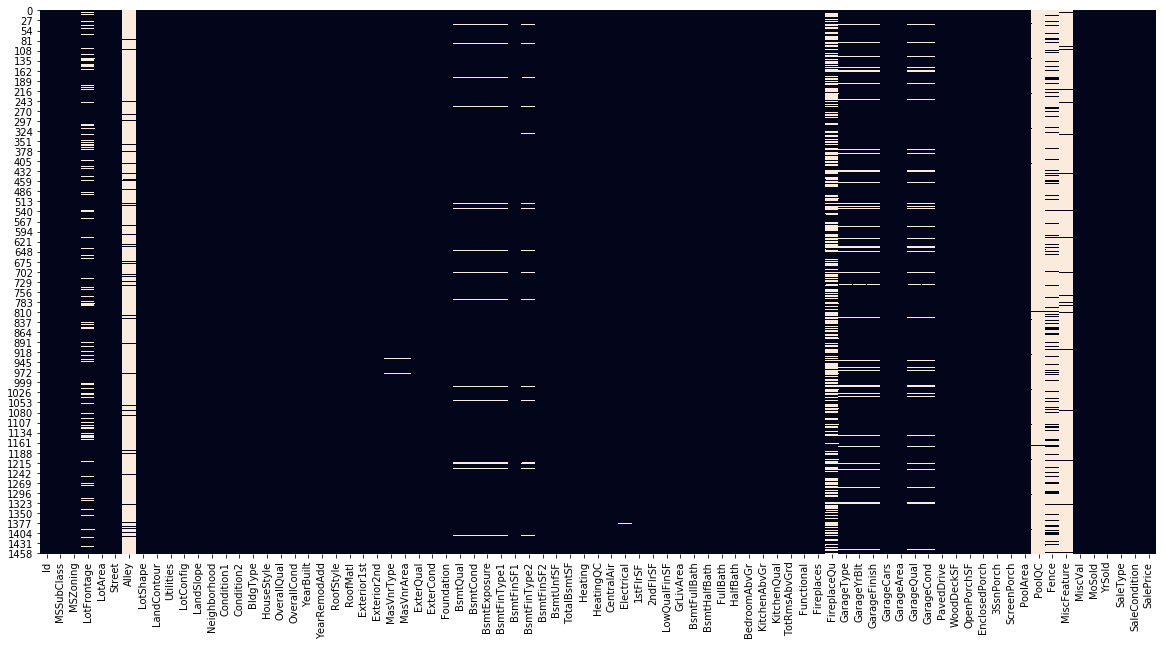

In [5]:
plt.figure(figsize=(20,10))
sns.heatmap(original_data.isnull(), cbar=False)
data = data.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

# Drop variables with very imblanced categories or mostly missing
data = data.drop(columns = ['Street', 'Utilities', 'LowQualFinSF', 'MiscVal'])

### Remove features that are redundant given other variables

We then remove aggregated variables that are very close to the sum of its component parts. For instance, TotalBsmtSF is the approximately sum of the BsmtFinSF1, BSmtUnfSF and BsmtFinSF2. Likewise with GrLivArea. There are some minor discrepancies, but I assume that those are immaterial for our analysis and not large/frequent enough to matter. 

GarageArea / GarageCars is an interesting case, as these two variables capture a similar concept. Indeed, the two variables are highly correlated (see chart below). We keep both in for now, but may decide to remove the 'less informative' one later (e.g. GarageCars). 

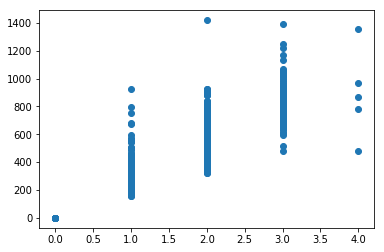

In [6]:
##################
### BASEMENTSF ###
# Drop the aggregate BsmtSF variable
test = pd.DataFrame()
test['DiffBsmtSF'] = original_data["TotalBsmtSF"] - original_data['BsmtFinSF1'] - original_data['BsmtUnfSF'] - original_data['BsmtFinSF2']
test['DiffBsmtSF'].value_counts()

# Remove variable
data = data.drop(columns=['TotalBsmtSF'])

##################
### GRLIVAREA ###
# Is GrLivArea simply the sum of 1st and 2nd?
# Most of hte time it is - there are 5 observations that are not, but doesn't seem like a goood reason to keep
test = pd.DataFrame()
test['GrLivArea'] = original_data["GrLivArea"]
test['1stAnd2nd'] = original_data["1stFlrSF"] + original_data["2ndFlrSF"]
test['Diff'] = test['GrLivArea'] - test['1stAnd2nd']
test['Diff'].value_counts()

###################
### GARAGECARS ###
data = data.drop(columns = ['GrLivArea'])
original_data['GarageCars'].value_counts()
plt.scatter(original_data['GarageCars'],original_data['GarageArea'])
#data = data.drop(columns=['GarageCars']) # KEEP FOR NOW, but garage area may be better than garage cars

###################
### DATETIME    ###
# Change date to ordinal representation:
data['YrMoSold'] = data['YrSold'].astype(int).astype(str) + "/" + data['MoSold'].astype(int).astype(str) + "/1"
data['YrMoSold'] = data['YrMoSold'].apply(lambda x: dt.strptime(x, "%Y/%m/%d").date().toordinal())

In [7]:
#############################
# Save the original variable 
data_LotFrontage_original = data['LotFrontage'].copy()

# Impute all numeric missings (all dummy missings are coded 0)
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
data_numeric = imp.fit_transform(data.select_dtypes(exclude='object'))
data_numeric = pd.DataFrame(data_numeric, columns = data.select_dtypes(exclude='object').columns)
data = pd.concat([data.select_dtypes(include='object'), data_numeric], axis = 1)

### Combine sparse categories in some features

Condition and Exterior features have many sparse levels - we group levels that have very few observations to obtain a bigger category. 

In [8]:
# Combine categories - very thin categories
# Condition1
data['Condition1'] = np.where(data['Condition1']=='Norm', 'Norm', 'Not_Norm')
data['Condition2'] = np.where(data['Condition2']=='Norm', 'Norm', 'Not_Norm')

# Exterior1st
data['Exterior1st'] = np.where(data['Exterior1st'].isin(['BrkComm', 'Stone', 'AsphShn', 'ImStucc', "CBlock", "WdShing", "Stucco", "AsbShng"]), 'Other', data['Exterior1st'])
data['Exterior2nd'] = np.where(data['Exterior2nd'].isin(['Brk Cmn', 'Stone', 'AsphShn', 'Other', "CBlock", "WdShing", "Stucco", "AsbShng"]), 'Other', data['Exterior1st'])


### One-Hot-Encoding for Categoricals

We use one-hot encoding to encode categorical features and combine the condition and exterior variables into one variable each. 

In [9]:
##########################
# Binarize all categorical (one-hot)
data = pd.get_dummies(data)

In [10]:
# Simplify the Condition Feature
data['Condition_Norm'] = data['Condition1_Norm'] + data['Condition2_Norm']
data['Condition_Not_Norm'] = data['Condition1_Not_Norm'] + data['Condition2_Not_Norm']
data['Condition_Norm'] = np.where(data['Condition_Norm']==2, 1, data['Condition_Norm'])
data['Condition_Not_Norm'] = np.where(data['Condition_Not_Norm']==2, 1, data['Condition_Not_Norm'])

# Simplify the Exterior Feature
data['Exterior_VinylSd'] = data['Exterior1st_VinylSd'] + data['Exterior2nd_VinylSd']
data['Exterior_HdBoard'] = data['Exterior1st_HdBoard'] + data['Exterior2nd_HdBoard']
data['Exterior_MetalSd'] = data['Exterior1st_MetalSd'] + data['Exterior2nd_MetalSd']
data['Exterior_Wd Sdng'] = data['Exterior1st_Wd Sdng'] + data['Exterior2nd_Wd Sdng']
data['Exterior_Plywood'] = data['Exterior1st_Plywood'] + data['Exterior2nd_Plywood']
data['Exterior_Other']   = data['Exterior1st_Other']   + data['Exterior2nd_Other']
data['Exterior_CemntBd'] = data['Exterior1st_CemntBd'] + data['Exterior2nd_CemntBd']
data['Exterior_BrkFace'] = data['Exterior1st_BrkFace'] + data['Exterior2nd_BrkFace']

data['Exterior_VinylSd'] = np.where(data['Exterior_VinylSd'] == 2, 1, data['Exterior_VinylSd'])
data['Exterior_HdBoard'] = np.where(data['Exterior_HdBoard'] == 2, 1, data['Exterior_HdBoard'])
data['Exterior_MetalSd'] = np.where(data['Exterior_MetalSd'] == 2, 1, data['Exterior_MetalSd'])
data['Exterior_Wd Sdng'] = np.where(data['Exterior_Wd Sdng'] == 2, 1, data['Exterior_Wd Sdng'])
data['Exterior_Plywood'] = np.where(data['Exterior_Plywood'] == 2, 1, data['Exterior_Plywood'])
data['Exterior_Other'] = np.where(data['Exterior_Other'] == 2, 1, data['Exterior_Other'])
data['Exterior_CemntBd'] = np.where(data['Exterior_CemntBd'] == 2, 1, data['Exterior_CemntBd'])
data['Exterior_BrkFace'] = np.where(data['Exterior_BrkFace'] == 2, 1, data['Exterior_BrkFace'])

cols_to_drop = list(filter(lambda x: re.search(r'Condition1|Condition2|Exterior1|Exterior2', x), data.columns))
data = data.drop(columns=cols_to_drop)

### Convert features to the right type

In [11]:
data['OverallQual'] = original_data['OverallQual'].astype('category')
data['OverallCond'] = original_data['OverallCond'].astype('category', ordered=True)
data['MSSubClass'] = original_data['MSSubClass'].astype('category')

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


### Impute features

- There are several variables that are missing substantial amount of data; however, one of them is especially critical for predicting home prices - the Lot Frontage. We use a kNN to impute the missing lot frontages - a cursory look at the distribution shows that the values follow a tighter, but normal-ish distribution. This is similar to the distribution of the nonmissing data. 

- Not shown here is a series of tests we ran to compare the accuracy when using the median imputation vs. the more precise kNN imputation. The results are very close (difference is to the fourth decimal place). In linear regression, the kNN imputation does marginally better regardless of the regularization used. In Random Forest - the model with kNN imputed values actually does worse for iterations with simpler trees and better for iterations with more complex trees. We suspect that this might be because more complex trees may be more likely to overfit imputed values.

- Regardless, we think the evidence points marginally in favor of using the imputation. 

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


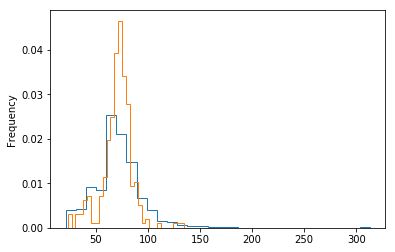

In [12]:
# Impute one or two key variables that are missing a substantial amount of data
# Normalize data before running 
scaler = StandardScaler(copy=True)
data_scaled = scaler.fit_transform(data.values)
data_scaled = pd.DataFrame(data_scaled, index = data.index, columns = data.columns)

# For example, Lot Frontage
knn = KNeighborsRegressor(n_neighbors=5, weights = 'distance')

# Isolate training data and missing data
notmissing_flag = data_LotFrontage_original.notnull()
missing_flag = data_LotFrontage_original.isnull()

# Define test data
lotfrontage_data = data_scaled[notmissing_flag].drop(columns='LotFrontage')
lotfrontage_labels = data_LotFrontage_original[notmissing_flag]

# test missing (prediction data)
lotfrontage_testdata = data_scaled.drop(columns='LotFrontage')

# Use KNN to predict missing data
knn.fit(lotfrontage_data, lotfrontage_labels)
lotpredictions = knn.predict(lotfrontage_testdata).astype(int)

# Plug it back into training data
data_LotFrontage_imputed = data_LotFrontage_original.copy()
data_LotFrontage_imputed[missing_flag] = lotpredictions
data_LotF_df = pd.DataFrame(np.column_stack((data_LotFrontage_imputed, missing_flag)), columns = ['LotFrontage_Imputed', 'Missing'])

# Plot the two histograms:
dataforplot = data_LotF_df.groupby('Missing')['LotFrontage_Imputed']
dataforplot.plot(kind='hist', bins = 30, density = True, histtype = 'step')

# Plug back into the data
data_LotFrontage_imputed_df = pd.DataFrame({'LotFrontage_Imputed': data_LotFrontage_imputed})
data = pd.concat([data.drop(columns='LotFrontage'), data_LotFrontage_imputed_df], axis = 1)

### Add new features

In [13]:
data['Basement'] = np.where(data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['BsmtUnfSF'] > 1, 1, 0)
data['WoodDeck'] = np.where(data['WoodDeckSF'] > 0, 1, 0)

### PCA

First we tried PCA without scaling and found that the first Principal Component captured 99% of the variation! This seemed too good to be true - indeed it was as our underlying data was not normalized or standardized. So most of the variation came from variables that were very large in units (e.g. LotSize). We validated this and saw that the units of the PCA itself were uncannily similar to LotSize; and that the principal components were also highly correlated with the LotSize variable.

After normalizing the underlying data we found that the PCA made more sense: even 50 components only explained 75% of the variance. 

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0,0.5,'Incremental Explained Variance')

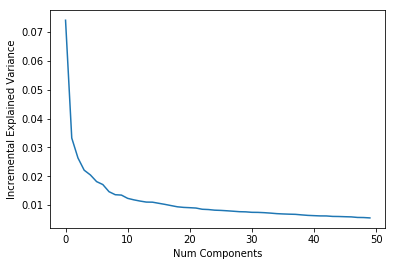

In [14]:
# Initialize parameters 
num_components = 50
data_for_pca = data.drop(columns=['YrMoSold', 'SalePrice', 'Id', 'LogSalePrice'])
pca_names = ['pca_' + str(i) for i in range(num_components)]

# First scale
scaler = StandardScaler(copy=True)
data_scaled = scaler.fit_transform(data_for_pca.values)
data_scaled = pd.DataFrame(data_scaled, index = data_for_pca.index, columns = data_for_pca.columns)

# Fit PCAe
pca = PCA(n_components=num_components)
data_pca = pca.fit_transform(data_scaled)
data_pca = pd.DataFrame(data_pca, columns=pca_names)

# Show Results
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Num Components')
plt.ylabel('Incremental Explained Variance')

In [15]:
# Cbind to dataframe
data = pd.concat([data.reset_index(drop=True), data_pca], axis = 1)

### Feature Interactions

- First we investigate the pairwise correlation between all variables and identify any set variables that are highly correlated. This led us to discover the redundant sets of variables discussed above.
- Further, we examine what variables seem to drive most of the variation in the dataset (by looking at those that are highly correlated with the top 5 principal components). Based on the PCA we might surmise that most of the variation in homes is associated with the number/types of rooms and the size of home; less so the meta-attributes (e.g. year sold). And, as expected, the principal components are uncorrelated with each other, by construction. 
    - PCA_0 seems to be capturing most of the variation that is linearly correlated with SalePrice (even though saleprice and its derivatives were not used in the generation of the PCA)
    - PCA_1 seems to be capturing variation associated with the discrete features in the home (e.g. number of baths, rooms, kitchen etc.)
    - PCA_2 seems to be capturing variation associated with the size of the home (SF, Frontage, LotArea, etc.)
    
- In testing (not shown here), PCA with the top 50 components does not improve accuracy (it is actually worse!) It is betwen 1-2 points worse for linear regression and for random forest on various combinations. We decide to exclude the use of the principal components for modeling. 

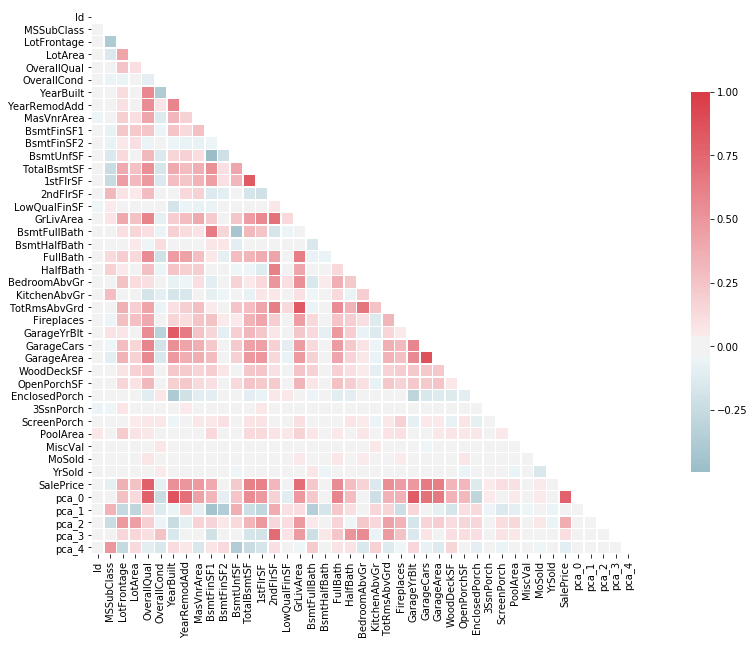

In [16]:
data_for_visual = original_data.select_dtypes(exclude='object')
data_for_visual = pd.concat((data_for_visual, data_pca.iloc[:,0:5]), axis = 1)

# Correlation matrix
plt.figure(figsize=(20,10))
corr = data_for_visual.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

### Algorithmic Feature Selection method
- We use this to sense check the range of important features. We find several interesting observations:
    - Principal components are not necessarily the most predictive of the target variable - other variables, such as size-related variables still rank higher than several of the top 5 principal components - See below. This makes sense because PCA only tries to create components that maximize the variance of the feature vectors and does not consider the target variable. 

In [17]:
# Remove target variables
remove_variables = ['SalePrice', 'LogSalePrice']

# Use random forest to remove feature vectors
rf = RandomForestRegressor()
rf.fit(data.drop(columns=remove_variables), data['SalePrice'])

# Set up data frame to show feature importance including PCA variables
feature_importances = pd.DataFrame(rf.feature_importances_.round(4),
                                   index = data.drop(columns=remove_variables).columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances[0:10])

# Set up data frame to show feature importance excluding PCA variables
remove_variables_pca = ['SalePrice', 'LogSalePrice', *pca_names]

rf.fit(data.drop(columns=remove_variables_pca), data['SalePrice'])
feature_importances_wopca = pd.DataFrame(rf.feature_importances_.round(4),
                                   index = data.drop(columns=remove_variables_pca).columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances_wopca[0:10])

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


             importance
OverallQual      0.3964
pca_0            0.3044
pca_2            0.0815
pca_3            0.0257
2ndFlrSF         0.0224
1stFlrSF         0.0177
pca_1            0.0142
LotArea          0.0094
GarageArea       0.0074
pca_5            0.0055
                     importance
OverallQual              0.6363
2ndFlrSF                 0.0565
1stFlrSF                 0.0497
LotArea                  0.0316
BsmtFinSF1               0.0309
GarageCars               0.0306
GarageArea               0.0138
TotRmsAbvGrd             0.0127
LotFrontage_Imputed      0.0096
FullBath                 0.0086


### Export the Data

In [18]:
# Final data to CSV file
data.to_csv('clean_data.csv')

# Final data to pickle file
outfile = open('clean_data_pickle','wb')
pk.dump(data, outfile)
outfile.close()